# 互评作业1: 数据探索性分析与预处理

## 作业要求
1. 问题描述  
本次作业中，将对合成的数据集进行探索性分析与预处理。  

2. 数据集  
需要分析的数据集：  

10G数据：10G_data_new.torrent  
30G数据：30G_data_new.torrent  


## 数据分析

在进行数据分析之前，导入必要的包并且设置中文字体。

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import os
from scipy import stats

plt.rcParams['font.sans-serif'] = ['SimHei'] # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

# 通过后面分析得到的重要全局变量
data_dir_path = ".\\10G_data_new"
single_file_len = 5625000
file_num = 8

### 探索性分析

对于崭新的数据集，我们几乎不了解其中的内容。先用Pandas读取其中一个文件的内容进行了解。

In [ ]:
data_dir_path = ".\\30G_data_new"
df = pd.read_parquet(data_dir_path + '/part-00000.parquet')

print(f"Dataframe 占用内存大小为：{df.memory_usage(deep=True).sum() / 1024 ** 3}")
print(f"Dataframe 规模为：{df.shape}")
print("展示前5行： ", df.head())
print("展示所有属性数据类型：", df.dtypes)

运行之后大致了解了单个文件的Dataframe占用内存大小，数据库规模，属性名称及属性数据类型。  
注意到有一个特殊的属性名为purchase_history。该属性包含多个对象，以json格式存储。用json模组解析文件中第一个purchase_history对象，并且观察其中的某些对象。

In [ ]:
p_h = json.loads(df.loc[0, 'purchase_history'])
print(f"第0行数据的purchase_history: {p_h}")
print(f"该用户的平均消费额:{p_h['avg_price']}")
print(f"该用户购买次数:{len(p_h['items'])}")

第0行数据的purchase_history: {'avg_price': 4041, 'categories': '文具', 'items': [{'id': 8852}, {'id': 2079}, {'id': 5043}], 'payment_method': '微信支付', 'payment_status': '部分退款', 'purchase_date': '2021-09-30'}
该用户的平均消费额:4041
该用户购买次数:3


经过对数据集的初始，大致了解了数据集的内容。相关基本信息总结如下：
单个文件在dataframe对象中的大小
10GB数据集 ->  8.5 GB
30GB数据集 -> 12.0 GB

数据集的列名
列名                  data_type   property_type   Size (30GB)
id                    int         序数            1.2e-7
timestamp             str         数值            6.3e-2
user_name             str                         6.4e-1
fullname              str                         6.9e-1
email                 str                         5.9e-1
age                   int         数值            6.3e-2
income                float       数值            6.3e-2
gender                str         标称            6.6e-1
country               str         标称            6.8e-1
address               str                         8.2e-1
purchase_history      str (json)  (multiple)      3.1
  average_price       float       (数值)               
  category            str         (标称)
  items               list        (数值——len)
is_active             bool        二元            7.9e-3
registration_date     str         数值            5.3e-1
phone_number          str                         3.7
login_history

下面对每个属性进行遍历，以探究是否有异常值以及如何进行预处理。在这个环节绘制直方图进行探究。

(8437500, 1)
(8437500, 1)
(8437500, 1)
(8437500, 1)
(8437500, 1)
(8437500, 1)
(8437500, 1)
(8437500, 1)
(8437500, 1)
(8437500, 1)
(8437500, 1)
(8437500, 1)
(8437500, 1)
(8437500, 1)
(8437500, 1)
(8437500, 1)


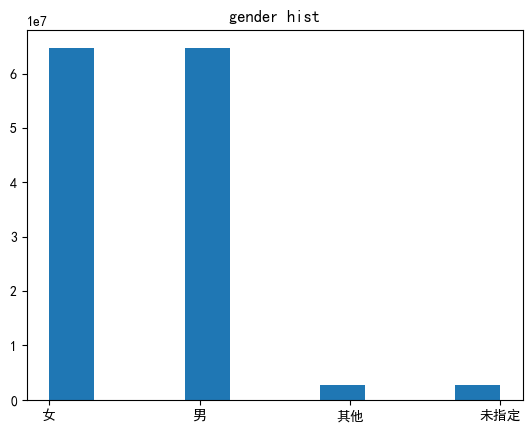

In [ ]:
# 可以一次对多个属性进行遍历，这里为了节省内存每次只研究一个属性

property_list = ['gender']
series_list = [pd.Series()]  * len(property_list)

for dirname, _, filenames in os.walk(data_dir_path):
    for filename in filenames:
        data_path = os.path.join(dirname, filename)
        # 为了节省时间和空间只读取需要的列
        df = pd.read_parquet(data_path, columns=property_list)
        print(df.shape)

        for index, property in enumerate(property_list):
            series_list[index] = pd.concat([series_list[index], df[property]])


# 绘制直方图

list_len = len(property_list)
for index, property in enumerate(property_list):
    plt.subplot(1, list_len, index + 1)
    plt.title(property + " hist")
    plt.hist(series_list[index])

plt.show()

### 数据预处理
经过以上阐述的绘制直方图对数据的分布进行分析，对数据的质量进行了初步的评价。对于具体每一项数据的质量，可以采用编写脚本或者使用正则表达式的方法逐条分析，或者采用人工观察。在这里采用了人工观察，结合直方图的结果，得出的数据质量的结论如下：  
数据的gender属性存在多个值为“其他”情况。其余数据未发现问题。  
鉴于社会道德通常认为gender属性应该只为“男”、“女”或者用户为了隐私而为设置具体性别，因此数据预处理环节将所有性别为“其他”视为异常值，“未指定”视为缺失值。  
为此，先统计异常值和缺失值占比。

In [ ]:
gender_series = pd.Series()

for dirname, _, filenames in os.walk(data_dir_path):
    for filename in filenames:
        data_path = os.path.join(dirname, filename)
        df = pd.read_parquet(data_path, columns=["gender"])
        gender_series = pd.concat([gender_series, df["gender"]])

abn_nums = len(gender_series[gender_series[:]=="其他"])
mis_nums = len(gender_series[gender_series[:]=="未指定"])

print(f"异常值行数为：{abn_nums}")
print(f"异常值占全部数据比例为：{(100 * abn_nums / (single_file_len * file_num)):.3f}%")

print(f"缺失值行数为：{mis_nums}")
print(f"缺失值占全部数据比例为：{(100 * mis_nums / (single_file_len * file_num)):.3f}%")

print(f"所有有问题行数为：{abn_nums + mis_nums}")
print(f"缺失值占全部数据比例为：{(100 * (abn_nums + mis_nums) / (single_file_len * file_num)):.3f}%")

del gender_series


异常值行数为：2698372
异常值占全部数据比例为：1.999%
缺失值行数为：2698564
缺失值占全部数据比例为：1.999%
所有有问题行数为：5396936
缺失值占全部数据比例为：3.998%


对数据中存在的异常值和缺失值进行统计，就30GB数据而言，异常值数量为2698372，占比1.999%；缺失值数量为2698564，缺失值占比1.999%.  
由于该数据中存在的异常值和缺失值会对有关性别的数据分析造成影响，因此将相关数据进行删除操作。删除后数据量减少3.998%，对于30GB数据而言减少为28.80GB.  
以下操作生成新的数据集以备分析。

In [ ]:
# for dirname, _, filenames in os.walk(data_dir_path):
#     for filename in filenames:
#         data_path = os.path.join(dirname, filename)
#         df = pd.read_parquet(data_path)
#         df = df[df[("gender" != "其他") & ("gender" != "未指定")]]
#         # 覆盖原文件以节省磁盘空间
#         df.to_parquet(data_path)
#         break

### 数据可视化
    在数据可视化部分，先对于单个属性的分布进行可视化。
-   对于标称属性，使用绘制直方图的方式进行可视化。可视化方法见探索性分析部分。
-   对于数值属性，单个数值属性采用绘制直方图和盒图的方式进行可视化。多个数值属性采用散点图的方式进行可视化。下面的代码探究了income属性的直方图、盒图以及income属性和avg_price的散点图。
    

读入数据块占用内存：2.122GB
执行时间：33.274秒
读入数据块占用内存：2.122GB
执行时间：26.243秒
读入数据块占用内存：2.122GB
执行时间：26.627秒
读入数据块占用内存：2.122GB
执行时间：25.655秒
读入数据块占用内存：2.122GB
执行时间：25.611秒
读入数据块占用内存：2.122GB
执行时间：27.429秒
读入数据块占用内存：2.122GB
执行时间：26.718秒
读入数据块占用内存：2.122GB
执行时间：25.464秒
[999999.99  10000.  ]
[0.01 0.  ]


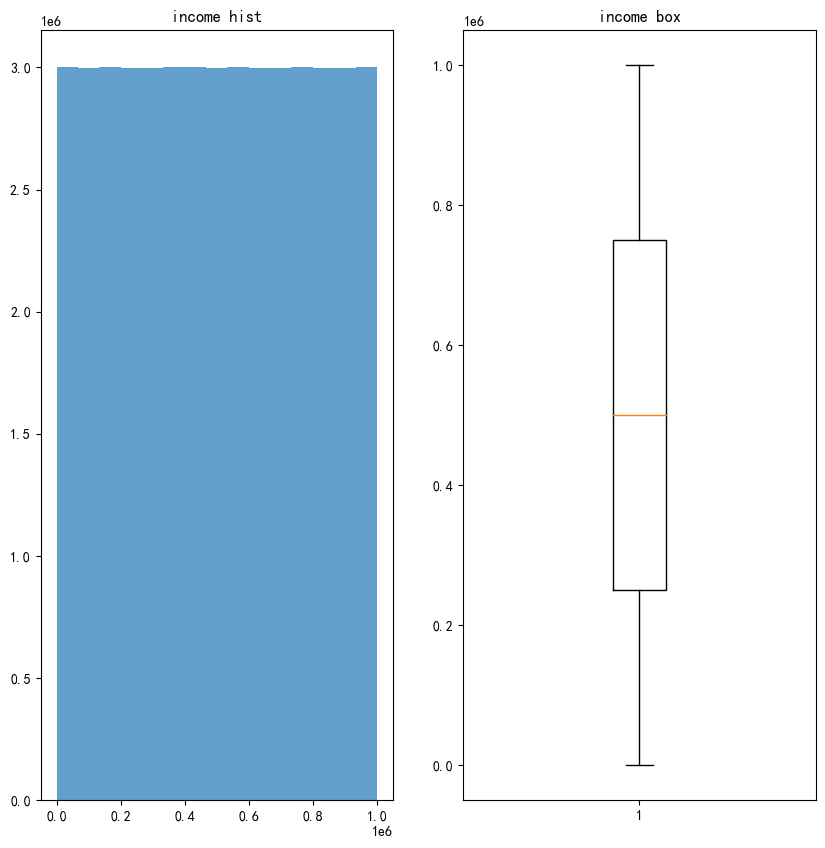

In [ ]:
import time

property_name_1 = 'income'
property_name_2 = 'purchase_history'
property_list = [property_name_1, property_name_2]
real_file_len = single_file_len
array_len = real_file_len * file_num
digit_data_array = np.zeros([array_len, 2])

for dirname, _, filenames in os.walk(data_dir_path):
    for index, filename in enumerate(filenames):
        
        start_time = time.time()
        
        data_path = os.path.join(dirname, filename)
        df = pd.read_parquet(data_path, columns=property_list)
        print(f"读入数据块占用内存：{(df.memory_usage(deep=True).sum() / 1024 / 1024 / 1024):.3f}GB")
        start = index * real_file_len
        end = (index + 1) * real_file_len

        digit_data_array[start: end, 0: 1] = df[[property_name_1]]

        for j, item in enumerate(df['purchase_history']): 
            p_h_json = json.loads(item)
            digit_data_array[j, 1] = p_h_json['avg_price']

        end_time = time.time()
        print(f"执行时间：{(end_time - start_time):.3f}秒")

print(digit_data_array.max(axis=0))
print(digit_data_array.min(axis=0))

# 绘制直方图、盒图

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title(property_name_1 + " hist")
plt.hist(digit_data_array[:, 0],
         bins=15,
         alpha=0.7)

plt.subplot(1, 2, 2)
plt.title(property_name_1 + " box")
plt.boxplot(digit_data_array[:, 0])

plt.show()

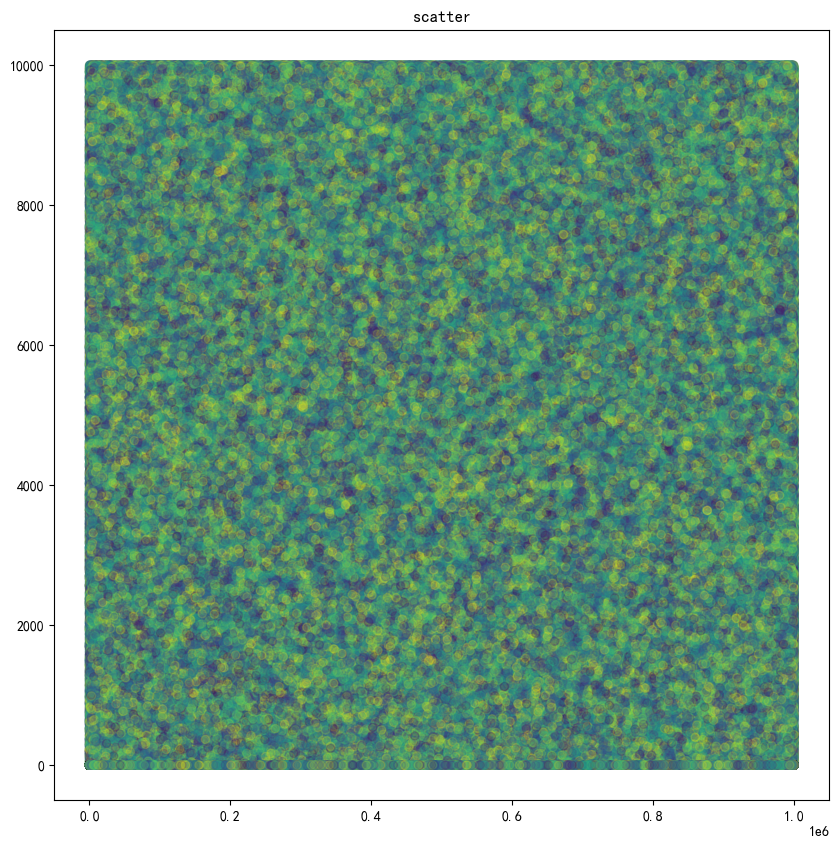

In [ ]:
# 绘制散点图、q-q图
colors = np.random.rand(digit_data_array.shape[0])       # 随机颜色值
cmap = 'viridis'

plt.figure(figsize=(10, 10))

plt.title("scatter")
plt.scatter(digit_data_array[:, 0], digit_data_array[:, 1], alpha=0.2, c=colors, cmap=cmap)

plt.show()

### 分析目标

-   用户行为分析  
    在数据分析环节，对用户的年龄、收入、性别、国家、地址、平均消费额等属性绘制直方图和盒图进行分析，并且通过绘制散点图的方式对（年龄、平均消费额），（收入、平均消费额），（性别、平均消费额），（年龄、收入）等多对属性进行分析以后，发现所有的用户属性均为平均分布，所有统计量之间的相关系数均接近于0，不存在任何有价值的用户行为。因此，针对这类用户不需要采取任何针对性营销措施，而是应该平均地分配营销资源。

## 总结

-   关键代码运行时间如下：  
    ![30G代码运行时间1](./images/30-1.png)  
    ![30G代码运行时间2](./images/30-2.png)  
    ![10G代码运行时间1](./images/10-1.png)  
    ![10G代码运行时间2](./images/10-2.png)  